## Step 0: import data and split

Import price data to train and test on

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_prices = pd.read_excel('Price.xlsx')
df_prices = df_prices.loc[df_prices['PriceArea'] == 'DK1']
df_prices.index = pd.to_datetime(df_prices['HourDK'])
df_prices = df_prices["PriceDKK"]
print("Total number of observations: ", len(df_prices))

Total number of observations:  23783


Plot prices to get an idea of how the price develops

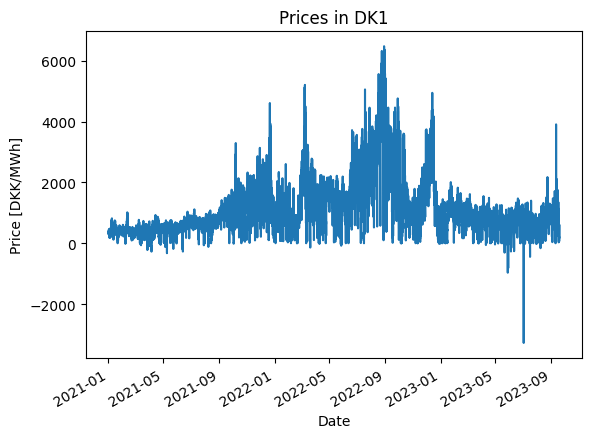

In [2]:
df_prices.plot(title = "Prices in DK1", xlabel = "Date", ylabel = "Price [DKK/MWh]")
plt.show()

## Step 1: Problem formulation
Define actions and states, and allowed actions in different states. Only depends on SOC

In [20]:
# Extract prices for 2023 as these appear to be stationary
prices = df_prices[df_prices.index.year == 2023].values

# Set of possible actions for battery
ACTIONS = ["Charge", "Discharge", "Do nothing"]

# Define the state space for prices and SOC
PRICE_STATE = ["Lowest", "Lower", "Medium", "Higher", "Highest"]
SOC_STATE = ["20%", "40%", "60%", "80%", "100%"]

# Define the allowed actions for each state, depends only on SOC
ALLOWED_ACTIONS = {"20%":  ["Charge",              "Do nothing"], 
                   "40%":  ["Charge", "Discharge", "Do nothing"],
                   "60%":  ["Charge", "Discharge", "Do nothing"],
                   "80%":  ["Charge", "Discharge", "Do nothing"],
                   "100%": [          "Discharge", "Do nothing"],}

# Initialize the lookup-table of the transition probabilities
P_ssa_array = np.empty((len(PRICE_STATE), len(SOC_STATE), len(ACTIONS)), dtype=object)

## Step 2: Discretize states and estimate probability
Discretize, prepare, and estimate probability of transitioning from one price state to another. Also compute representative prices for each state

In [4]:
def price_state(prices):
    # Split prices into discrete states
    percentiles = np.percentile(prices, np.linspace(0, 100, len(PRICE_STATE) + 1))
    price_states = np.array([(percentiles[i] <= prices) & (prices < percentiles[i+1]) for i in range(len(PRICE_STATE))], dtype=int)
    
    # Compute probability of being in a price state given the current price state.
    # Assumed independent of SOC state and action
    # price_prop = P(s'|s) -> price_prop[i,j] = P(s'=j|s=i)
    price_prop = (price_states @ np.roll(price_states,-1).T) / (price_states).sum(axis=1)

    # Generate representative prices
    price_representative = np.array([prices[price_states[i] == 1].mean() for i in range(len(PRICE_STATE))])

    return price_prop, price_representative, percentiles

Compute the transitioning matrix for each given state (price and SOC) and action. Limit allowed actions

In [5]:
def P_ssa(price_prop, P_ssa_array):
    for i, ps in enumerate(PRICE_STATE):
        for j, ss in enumerate(SOC_STATE):
            for k, ac in enumerate(ACTIONS):
                # Given that we are in state ps, ss and take action ac
                # what is the probability of transitioning to each state (ps', ss')
                # i.e. P(s'=(ps', ss')| s=(ps, ss), ac)
                if ac in ALLOWED_ACTIONS[ss]:
                    if ac == "Charge":
                        c = 1
                    elif ac == "Discharge":
                        c = -1
                    else:
                        c = 0
                    SOC_prop = np.zeros((len(SOC_STATE)))
                    SOC_prop[j + c] = 1 # SOC state is deterministic given action

                    # state_trans = P(price'|price) * P(soc'|soc, action)
                    state_trans = price_prop[i, :].reshape(-1, 1) @ SOC_prop.reshape(1, -1)
                    P_ssa_array[i, j, k] = state_trans  # Assign to the correct variable
                else: # Impossible action, set P to zero
                    P_ssa_array[i, j, k] = np.zeros((len(PRICE_STATE), len(SOC_STATE)))

    return P_ssa_array


## Step 3.1: Definitions
Generate reward function. The reward is the expected revenue from the action, defined using representative prices for each price state and a fixed power

In [6]:
def rewards(price_state, action, price_representative, power = 100):
    # Reward based on revenue from charging/discharging
    if action == "Charge":
        reward = - power * price_representative[PRICE_STATE.index(price_state)]
    elif action == "Discharge":
        reward = power * price_representative[PRICE_STATE.index(price_state)]
    else:
        reward = 0
    return reward

Define a function for performing value iteration

In [7]:
def value_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representatives, P_ssa, gamma=0.9, epsilon=1e-6):
    """
    Perform value iteration for a 2D state space with given parameters.

    Parameters:
    - PRICE_STATE: List of discrete price states
    - SOC_STATE: List of discrete state of charge (SOC) states
    - ALLOWED_ACTIONS: A dictionary mapping each SOC state to a list of valid actions
    - rewards: A function `rewards(price_state, action)` that returns the immediate reward
    - P_ssa: Transition probability matrix
    - gamma: Discount factor (default 0.9)
    - epsilon: Convergence threshold (default 1e-6)

    Returns:
    - V: Optimal value function
    - policy: Optimal policy for each state
    """
    # Initialize the value function to 0 for all states
    V = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
    policy = np.zeros((len(PRICE_STATE), len(SOC_STATE)), dtype=object)
    count = 0
    policy_list = []
    while True:
        # Initialize the new value function
        V_new = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
        
        for i, ps in enumerate(PRICE_STATE):    # Iterate over price states
            for j, ss in enumerate(SOC_STATE):  # Iterate over SOC states
                # Get the valid actions for the current SOC state
                valid_actions = ALLOWED_ACTIONS[ss]

                # Compute the action values for each action
                action_value = [rewards(ps, ac, price_representatives) + gamma * np.trace(P_ssa[i,j,k] @ V.T)
                                      for k, ac in enumerate(ACTIONS) if ac in valid_actions]

                # Update the value function with the max action value
                V_new[i,j] = np.max(action_value)
                
                # Store the optimal action index
                policy[i, j] = valid_actions[np.argmax(action_value)]

        policy_list.append(policy)
        # Check for convergence
        count += 1
        if np.max(np.abs(V - V_new)) < epsilon:
            # print(f"Converged after {count} iterations")
            break

        # Update the value function
        V = V_new

    return V, policy, count, policy_list

Define a function for the policy iteration

In [8]:
def policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representatives, P_ssa, gamma=0.9, epsilon=1e-6):
    """
    Perform policy iteration for a 2D state space with given parameters.

    Parameters:
    - PRICE_STATE: List of discrete price states
    - SOC_STATE: List of discrete state of charge (SOC) states
    - ALLOWED_ACTIONS: A dictionary mapping each SOC state to a list of valid actions
    - rewards: A function `rewards(price_state, action)` that returns the immediate reward
    - P_ssa: Transition probability matrix
    - gamma: Discount factor (default 0.9)
    - epsilon: Convergence threshold (default 1e-6)

    Returns:
    - V: Optimal value function
    - policy: Optimal policy for each state
    - iterations: Number of iterations to convergence
    """
    
    def evaluate_policy(policy):
        """Evaluate a fixed policy to get the value function."""
        V = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
        while True:
            V_new = np.zeros_like(V)
            for i, ps in enumerate(PRICE_STATE):
                for j, ss in enumerate(SOC_STATE):
                    action = policy[i, j]
                    k = ACTIONS.index(action)
                    reward = rewards(ps, action, price_representatives)
                    V_new[i, j] = reward + gamma * np.trace(P_ssa[i, j, k] @ V.T)
            if np.max(np.abs(V - V_new)) < epsilon:
                break
            V = V_new
        return V

    # Initialize random policy
    policy = np.zeros((len(PRICE_STATE), len(SOC_STATE)), dtype=object)
    for j, ss in enumerate(SOC_STATE):
        policy[:, j] = np.random.choice(ALLOWED_ACTIONS[ss], len(PRICE_STATE))

    count = 0
    policy_list = [policy.copy()]
    while True:
        # Policy evaluation
        V = evaluate_policy(policy)
        
        # Policy improvement
        stable = True
        for i, ps in enumerate(PRICE_STATE):
            for j, ss in enumerate(SOC_STATE):
                valid_actions = ALLOWED_ACTIONS[ss]
                action_values = [
                    rewards(ps, ac, price_representatives) + gamma * np.trace(P_ssa[i, j, ACTIONS.index(ac)] @ V.T)
                    for ac in valid_actions]
                best_action = valid_actions[np.argmax(action_values)]
                if policy[i, j] != best_action:
                    policy[i, j] = best_action
                    stable = False
        policy_list.append(policy.copy())
        count += 1
        if stable:
            break

    return V, policy, count, policy_list


## Step 3.2: Usage
Split into training and testing

In [29]:
# Split the data into training, validation and test sets, with 80% training, of which 80% is used for training and 20% for validation  
def split_data(prices, train_test_fraction = 0.8, train_val_fraction = 0.8, n_test = None):
    if n_test is None:
        N = len(prices)
        train_test_split = int(np.floor(N * train_test_fraction))
        train_val_split = int(np.floor(train_test_split * train_val_fraction))

        x_train = prices[:train_test_split]
        x_train_train = x_train[:train_val_split]
        x_val = x_train[train_val_split:]
        x_test = prices[train_test_split:]
    else:
        N = len(prices)
        x_test = prices[-n_test:]
        x_train = prices[:-n_test]
        train_val_split = int(np.floor(len(x_train) * train_val_fraction))
        x_train_train = x_train[:train_val_split]
        x_val = x_train[train_val_split:]

    return x_train_train, x_val, x_train, x_test

x_train_train, x_val, x_train, x_test = split_data(prices)

print("Training set size: ", len(x_train))
print("Validation set size: ", len(x_val))
print("Test set size: ", len(x_test))

Training set size:  12018
Validation set size:  2404
Test set size:  3005


We can now define a function for simulating the actual operation of the battery based on a given policy

In [10]:
def simulate_policy_with_boundaries(real_prices, policy, percentiles_train, PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20):
    """
    Simulate hourly operation of a battery using a policy matrix and price state boundaries.

    Parameters:
    - real_prices: List of hourly price data.
    - policy: Policy matrix 
    - percentiles_train: The percentiles defining the price states (for digitizing the real prices).
    - PRICE_STATE: List of price state labels.
    - SOC_STATE: List of discrete SOC levels (percentage).
    - max_soc_percent: Maximum state of charge (percentage).
    - soc_step_percent: SOC increment in percentage (20% = 100 MW).

    Returns:
    - total_cost: Total cumulative cost/revenue from simulation.
    - hourly_profits: A list of profits/revenues for each hour.
    """
    # Initialize variables
    soc_percentage = 0  # Starting state of charge in percentage (0% means 0 MWh capacity)
    hourly_revenue = []  # List to store the profit for each hour

    # Map SOC_STATE to percentage levels (["20%", "40%", "60%", "80%", "100%"])
    soc_levels_percentage = np.array([int(s.strip('%')) for s in SOC_STATE])  # Convert SOC to percentage

    # Determine price state (index in PRICE_STATE)
    price_quantiles = np.digitize(real_prices, percentiles_train) - 1
    price_quantiles[price_quantiles < 0] = 0  # Assign values lower than the lowest percentile to the lowest bin
    price_quantiles[price_quantiles >= len(PRICE_STATE)] = len(PRICE_STATE) - 1  # Assign values higher than the highest percentile to the highest bin

    # Simulate hourly operation
    for hour, price in enumerate(real_prices):
        
        # Determine the price state for the current hour
        price_state_index = price_quantiles[hour]

        # Determine SOC state (index in SOC_STATE)
        soc_index = np.argmin(np.abs(soc_levels_percentage - soc_percentage))  # Find closest match to the current SOC percentage

        # Retrieve the action from the policy matrix (Charge, Discharge, Do nothing)
        action = policy[price_state_index, soc_index]

        # Calculate the revenue based on the action
        if action == "Charge":
            revenue = -100 * price  # Charging cost
        elif action == "Discharge":
            revenue = 100 * price
        else:
            revenue = 0
        hourly_revenue.append(revenue)  # Store profit for this hour


        # Update SOC based on the action (in percentage terms)
        if action == "Charge":
            # Increase SOC by 20% (100 MW = 100 MWh)
            soc_percentage = min(soc_percentage + soc_step_percent, max_soc_percent)  # Ensure SOC doesn't exceed 100%
        elif action == "Discharge":
            # Decrease SOC by 20% (100 MW = 100 MWh)
            soc_percentage = max(soc_percentage - soc_step_percent, 0)  # Ensure SOC doesn't go below 0%
        elif action == "Do nothing":
            # SOC remains the same (Do nothing)
            pass

    # Calculate total revenue and return hourly revenue
    total_revenue = sum(hourly_revenue)  
    return total_revenue, hourly_revenue  


The operation of the battery and its revenue can be determined for different gammas to find the optimal in the validation set using value iteration

Optimal gamma: 0.91


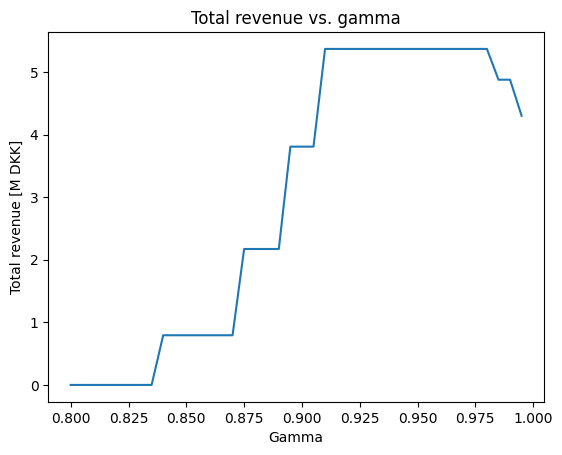

In [11]:
price_prop, price_representative, percentiles = price_state(x_train_train)
P_ssa_est = P_ssa(price_prop, P_ssa_array)

gammas = np.linspace(0.8, 0.995, 40)
revenues = []
for gamma in gammas:
    V, policy, count, policy_list = value_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=gamma)
    total_revenue_val, hourly_revenue_val = simulate_policy_with_boundaries(x_val, policy, percentiles, PRICE_STATE, SOC_STATE)
    revenues.append(total_revenue_val/1E6)

opt_gamma = gammas[np.argmax(revenues)] # Find the gamma that maximizes revenue
print(f"Optimal gamma: {opt_gamma}")

# Plot the total revenue as a function of gamma
plt.plot(gammas, revenues)
plt.xlabel("Gamma")
plt.ylabel("Total revenue [M DKK]")
plt.title("Total revenue vs. gamma")
plt.show()

144 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Converged after 220 iterations
Optimal policy:
[['Charge' 'Charge' 'Charge' 'Charge' 'Do nothing']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']]


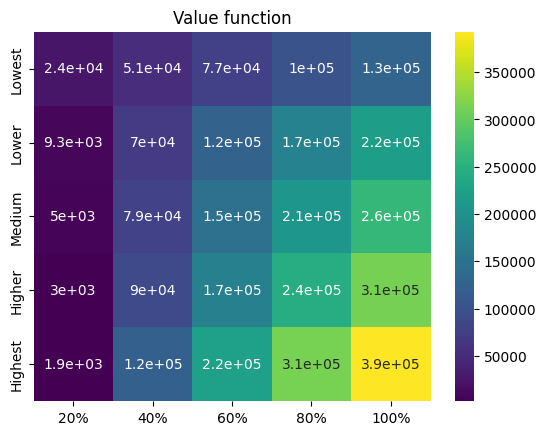

In [12]:
%timeit V, policy, count, policy_list = value_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma)
V, policy, count, policy_list = value_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma)

print("Converged after", count, "iterations")
print("Optimal policy:")
print(policy)

# Plot heatmap of the value function
sns.heatmap(V, annot=True, xticklabels=SOC_STATE, yticklabels=PRICE_STATE, cmap="viridis").set(title='Value function')
plt.show()

We can now repeat the process using the policy iteration

Optimal gamma: 0.91


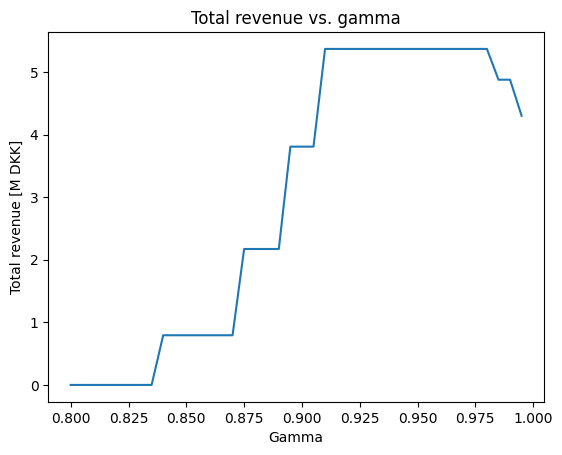

In [13]:
revenues = []
for gamma in gammas:
    V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=gamma)
    total_revenue_val, hourly_revenue_val = simulate_policy_with_boundaries(x_val, policy, percentiles, PRICE_STATE, SOC_STATE)
    revenues.append(total_revenue_val/1E6)

opt_gamma = gammas[np.argmax(revenues)] # Find the gamma that maximizes revenue
print(f"Optimal gamma: {opt_gamma}")

# Plot the total revenue as a function of gamma
plt.plot(gammas, revenues)
plt.xlabel("Gamma")
plt.ylabel("Total revenue [M DKK]")
plt.title("Total revenue vs. gamma")
plt.show()

97.4 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Converged after 3 iterations
Optimal policy:
[['Charge' 'Charge' 'Charge' 'Charge' 'Do nothing']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']]


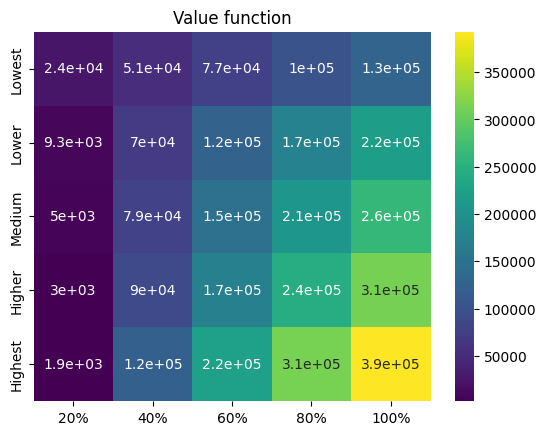

In [14]:
%timeit V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma)
V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma)

print("Converged after", count, "iterations")
print("Optimal policy:")
print(policy)

# Plot heatmap of the value function
sns.heatmap(V, annot=True, xticklabels=SOC_STATE, yticklabels=PRICE_STATE, cmap="viridis").set(title='Value function')
plt.show()

Comparing test profits with profits yielded if MDP was run on test data

In [15]:
price_prop, price_representative, percentiles = price_state(x_train)
P_ssa_est = P_ssa(price_prop, P_ssa_array)
V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma)
total_revenue_test, hourly_revenue_test1 = simulate_policy_with_boundaries(x_test, policy, percentiles, PRICE_STATE, SOC_STATE)

print("Total revenue on test set: ", np.round(total_revenue_test/1E6,2), "M DKK")
policy

Total revenue on test set:  4.09 M DKK


array([['Charge', 'Charge', 'Charge', 'Charge', 'Do nothing'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge']],
      dtype=object)

## Step 4: additions

### Step 4.1: Cumulative profit from intermediate policies

### Step 4.2: Using additional state spaces for price

### Step 4.3: Incentivise actions in reward function 
The current reward function only looks at revenue from charging or discharging. The reward function is very important for our learning and it can therefore be considered what would happen if we reward it differently.

In [ ]:
def rewards(price_state, action, price_representative, power = 100):
    # Reward based on revenue from charging/discharging
        # Reward ideling?
        # Add cost for charging and discharging?
        # Add reward for considering future?
    if action == "Charge":
        reward = - power * price_representative[PRICE_STATE.index(price_state)]
    elif action == "Discharge":
        reward = power * price_representative[PRICE_STATE.index(price_state)]
    else:
        reward = 0
    return reward

### Step 4.4: Use different lengths of data
Previously we have only used data from 2023 as the general price level changed from previous years. We can now examine what would happen if we used data dating further back. We will keep the test set the same to compare the models on equal terms.

Optimal gamma: 0.92


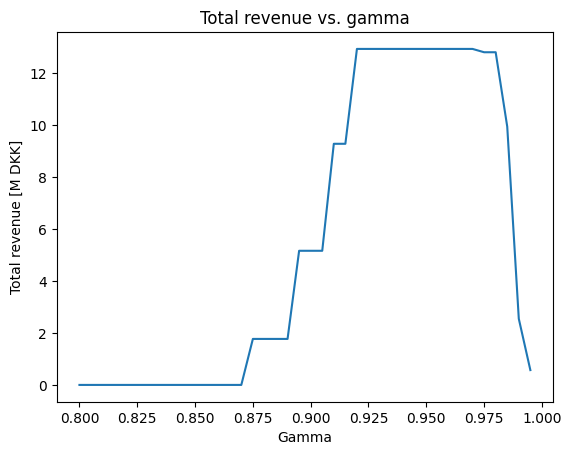

In [32]:
prices = df_prices[df_prices.index.year >= 2022].values
x_train_train, x_val, x_train, x_test = split_data(prices, n_test=1253)
price_prop, price_representative, percentiles = price_state(x_train_train)
P_ssa_est = P_ssa(price_prop, P_ssa_array)

revenues = []
for gamma in gammas:
    V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=gamma)
    total_revenue, hourly_revenue = simulate_policy_with_boundaries(x_val, policy, percentiles, PRICE_STATE, SOC_STATE)
    revenues.append(total_revenue/1E6)

opt_gamma = gammas[np.argmax(revenues)] # Find the gamma that maximizes revenue
print(f"Optimal gamma: {opt_gamma}")

# Plot the total revenue as a function of gamma
plt.plot(gammas, revenues)
plt.xlabel("Gamma")
plt.ylabel("Total revenue [M DKK]")
plt.title("Total revenue vs. gamma")
plt.show()

In [33]:
price_prop, price_representative, percentiles = price_state(x_train)
P_ssa_est = P_ssa(price_prop, P_ssa_array)

%timeit V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma)
V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma)
total_revenue, hourly_revenue = simulate_policy_with_boundaries(x_test, policy, percentiles, PRICE_STATE, SOC_STATE)

print("Converged after", count, "iterations")
print("Total revenue on test set: ", np.round(total_revenue/1E6,2), "M DKK")
policy

103 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Converged after 2 iterations
Total revenue on test set:  4.28 M DKK


array([['Charge', 'Charge', 'Charge', 'Charge', 'Do nothing'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge']],
      dtype=object)

We can now repeat the process using all available data, i.e. 2021-23

Optimal gamma: 0.92


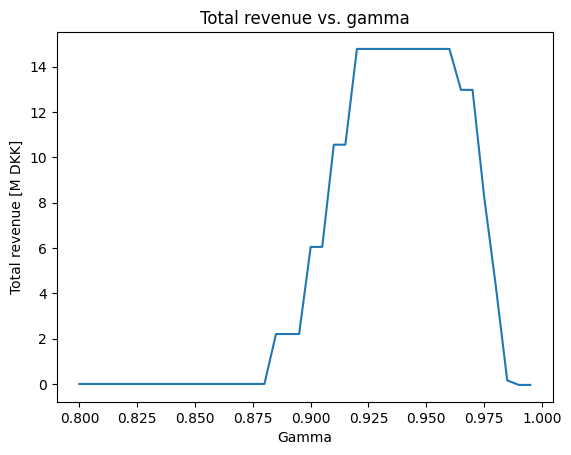

In [34]:
prices = df_prices.values
x_train_train, x_val, x_train, x_test = split_data(prices, n_test=1253)
price_prop, price_representative, percentiles = price_state(x_train_train)
P_ssa_est = P_ssa(price_prop, P_ssa_array)

revenues = []
for gamma in gammas:
    V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=gamma)
    total_revenue, hourly_revenue = simulate_policy_with_boundaries(x_val, policy, percentiles, PRICE_STATE, SOC_STATE)
    revenues.append(total_revenue/1E6)

opt_gamma = gammas[np.argmax(revenues)] # Find the gamma that maximizes revenue
print(f"Optimal gamma: {opt_gamma}")

# Plot the total revenue as a function of gamma
plt.plot(gammas, revenues)
plt.xlabel("Gamma")
plt.ylabel("Total revenue [M DKK]")
plt.title("Total revenue vs. gamma")
plt.show()

In [35]:
price_prop, price_representative, percentiles = price_state(x_train)
P_ssa_est = P_ssa(price_prop, P_ssa_array)

%timeit V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma)
V, policy, count, policy_list = policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma)
total_revenue, hourly_revenue = simulate_policy_with_boundaries(x_test, policy, percentiles, PRICE_STATE, SOC_STATE)

print("Converged after", count, "iterations")
print("Total revenue on test set: ", np.round(total_revenue/1E6,2), "M DKK")
policy

114 ms ± 7.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Converged after 3 iterations
Total revenue on test set:  3.82 M DKK


array([['Charge', 'Charge', 'Charge', 'Charge', 'Do nothing'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge']],
      dtype=object)

We observe that using only 2023 results in a profit of 4.09 MDKK, 2022-23 of 4.28 MDKK and 2021-23 of 3.82 MDKK. Interestingly including the extreme year of 2022 improves our model, while the addition of 2021 makes it worse. All models come up with the same policy, but the difference between them is how they split the prices into states.